In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from scipy.stats import f_oneway

**Info about original data:**
- Original data = Headway Data, 8-1-2023 to 9-30-2023.xlsx
- Number of observations: 350,328 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350328 entries, 0 to 350327
Data columns (total 30 columns):
Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   CALENDAR_ID                350328 non-null  int64         
 1   SERVICE_ABBR               350328 non-null  int64         
 2   ADHERENCE_ID               350328 non-null  int64         
 3   DATE                       350328 non-null  datetime64[ns]
 4   ROUTE_ABBR                 350328 non-null  int64         
 5   BLOCK_ABBR                 350328 non-null  int64         
 6   OPERATOR                   350328 non-null  int64         
 7   TRIP_ID                    350328 non-null  int64         
 8   OVERLOAD_ID                350328 non-null  int64         
 9   ROUTE_DIRECTION_NAME       350328 non-null  object        
 10  TIME_POINT_ABBR            350328 non-null  object        
 11  ROUTE_STOP_SEQUENCE        350317 non-null  float64       
 12  TRIP_EDGE                  350328 non-null  int64         
 13  LATITUDE                   350328 non-null  float64       
 14  LONGITUDE                  350328 non-null  float64       
 15  SCHEDULED_TIME             350328 non-null  object        
 16  ACTUAL_ARRIVAL_TIME        338869 non-null  object        
 17  ACTUAL_DEPARTURE_TIME      338860 non-null  object        
 18  ADHERENCE                  338860 non-null  float64       
 19  SCHEDULED_HDWY             274737 non-null  float64       
 20  ACTUAL_HDWY                266061 non-null  float64       
 21  HDWY_DEV                   265892 non-null  float64       
 22  ADJUSTED_EARLY_COUNT       350328 non-null  int64         
 23  ADJUSTED_LATE_COUNT        350328 non-null  int64         
 24  ADJUSTED_ONTIME_COUNT      350328 non-null  int64         
 25  STOP_CANCELLED             350328 non-null  int64         
 26  PREV_SCHED_STOP_CANCELLED  279999 non-null  float64       
 27  IS_RELIEF                  350328 non-null  int64         
 28  BLOCK_STOP_ORDER           350328 non-null  int64         
 29  DWELL_IN_MINS              338857 non-null  float64 
 
- We removed null values because there were only 265,892 observations with existing HDWY_DEV columns. New dataframe -> headway_data, 265884 entries (75.89%)
- Also removed outliers from the HDWY_DEV and ADHERENCE columns. New dataframe -> processed_data, 254299 entries (72% of original data OR 95.64% of data after removing null values). 
- Data cleanup was based on keeping the 99.9th percentile of the data's HDWY_DEV and ADHERENCE z-scores. Dataset was grouped into each UNIQUE_TRIP_ID (this is the unique ID for each trip on a specific day; trip numbers were reused after a couple days). Z-scores were calculated for the HDWY_DEV and ADHERENCE columns and if the values fell outside of the 99.9th percentile, which meant values below the 0.1st percentile and above the 99.9th percentile. 

In [2]:
processed_data = pd.read_csv("../data/processed_data.csv")
processed_data.head(2)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,HDWY_DEV_PERC,Z_HDWY_DEV,Z_ADHERENCE,UNIQUE_TRIP_ID,PREVIOUS_ADHERENCE,NEXT_ADHERENCE
0,120230801,1,99457899,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,0.0,0,80,0.0,-0.032222,-0.139835,0.510757,120230801_345106,NaN,-1.916666
1,120230801,1,99457898,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,0.0,0,70,0.0,0.056190,0.202259,0.244098,120230801_345106,-0.183333,-1.716666


**Question:** What is the relationship between adherence and headway deviation? 

In [3]:
lm = smf.ols('HDWY_DEV ~ ADHERENCE', data = processed_data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               HDWY_DEV   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                 6.073e+04
Date:                Thu, 09 Nov 2023   Prob (F-statistic):               0.00
Time:                        11:43:59   Log-Likelihood:            -7.3185e+05
No. Observations:              254299   AIC:                         1.464e+06
Df Residuals:                  254297   BIC:                         1.464e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.6159      0.011   -145.315      0.000      -1.638      -1.594
ADHERENCE     -0.5678      0.002   -246.427      0.000      -0.572      -0.563
==============================================================================
Omnibus:                    40022.024   Durbin-Watson:                   0.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           317317.174
Skew:                          -0.533   Prob(JB):                         0.00
Kurtosis:                       8.367   Cond. No.                         6.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Results:**
- The F-statistic is a test statistic used to assess the overall significance of the model. The F-statistic is 6.073e+04, and the p-value is 0.00, indicating that the model is statistically significant.
- The **intercept** is the predicted value of 'HDWY_DEV' when 'ADHERENCE' is zero.
- Both coefficients have very low p-values (close to 0), indicating that they are **statistically significant**.
- R-squared of 0.193, indicate that approximately 19.3% of the variance in HDWY_DEV is explained by the model.

mean(ADHERENCE) = -1.6159 - 0.5678(HDWY_DEV)

- For every one-minute change in 'ADHERENCE', 'HDWY_DEV' is expected to decrease by approximately -0.5678 minutes (or about 34 seconds). The negative sign means that as 'ADHERENCE' increases (the bus leaves before the scheduled time), 'HDWY_DEV' is expected to decrease (become more negative).

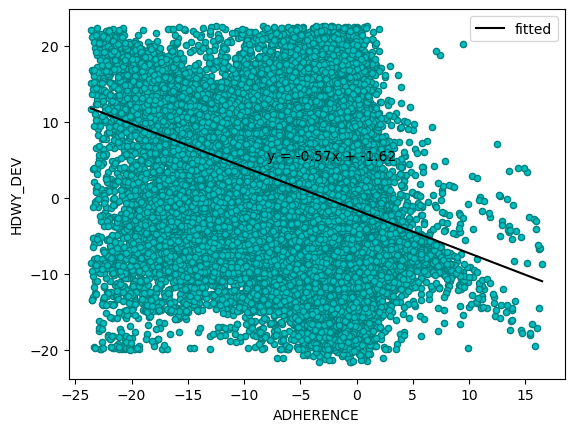

In [4]:
m = lm.params['ADHERENCE']  # Slope
b = lm.params['Intercept']  # Y-intercept
equation = f'y = {m:.2f}x + {b:.2f}'

ax = processed_data.plot(x = 'ADHERENCE', y = 'HDWY_DEV', kind = 'scatter', s = 20, color = 'c', edgecolor = 'teal', linewidth=1); #cyan
ax.text(
    -8, 5, # x and y coordinates
    equation,
    fontsize=10,
    color='black'
)

fit_df = pd.DataFrame({
    'ADHERENCE': np.linspace(
        start = processed_data['ADHERENCE'].min(),
        stop = processed_data['ADHERENCE'].max(), 
        num = 150)})
fit_df['fitted'] = lm.predict(fit_df)

fit_df.plot(x = 'ADHERENCE', y = 'fitted', ax = ax, color = 'black', label = 'fitted');

# plt.savefig('C:/Users/MJ/Data Science Bootcamp/Projects/temp/images/adherence_vs_dwydev.png');

**Question:** What is the relationship between previous adherence/ headway deviation on the next adherence/ headway deviation? 

In [5]:
# Check correlation to see how adherence at the first trip's first stop influences the adherence at the next stop
correlation = processed_data['PREVIOUS_ADHERENCE'].corr(processed_data['NEXT_ADHERENCE'])
print("Correlation between first stop adherence and next stop adherence:", correlation)

Correlation between first stop adherence and next stop adherence: 0.700549331688534


In [6]:
# Calculate lagged adherence values for each stop
processed_data['PREVIOUS_HDWY_DEV'] = processed_data.groupby('UNIQUE_TRIP_ID')['HDWY_DEV'].shift(1)
processed_data['NEXT_HDWY_DEV'] = processed_data.groupby('UNIQUE_TRIP_ID')['HDWY_DEV'].shift(-1)

# Check correlation to see how adherence at the first trip's first stop influences the adherence at the next stop
correlation = processed_data['PREVIOUS_HDWY_DEV'].corr(processed_data['NEXT_HDWY_DEV'])
print("Correlation between first stop headway deviation and next stop headway deviation:", correlation)

Correlation between first stop headway deviation and next stop headway deviation: 0.545366112026422


In [7]:
lm = smf.ols('NEXT_HDWY_DEV ~ PREVIOUS_HDWY_DEV', data = processed_data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          NEXT_HDWY_DEV   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                 5.515e+04
Date:                Thu, 09 Nov 2023   Prob (F-statistic):               0.00
Time:                        11:44:03   Log-Likelihood:            -3.6983e+05
No. Observations:              130280   AIC:                         7.397e+05
Df Residuals:                  130278   BIC:                         7.397e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0514      0.011      4.481      0.000       0.029       0.074
PREVIOUS_HDWY_DEV     0.5616      0.002    234.843      0.000       0.557       0.566
==============================================================================
Omnibus:                    18923.336   Durbin-Watson:                   1.531
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           224683.012
Skew:                           0.296   Prob(JB):                         0.00
Kurtosis:                       9.406   Cond. No.                         4.80
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

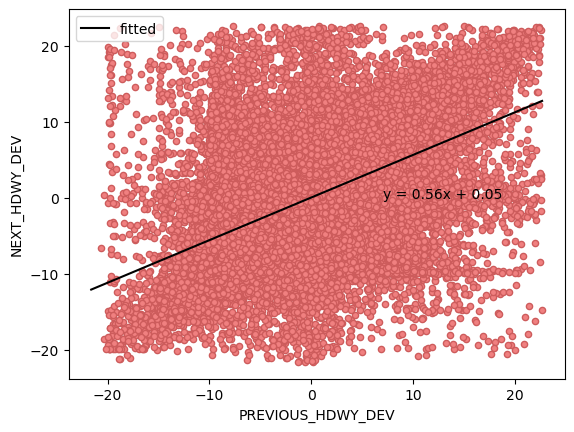

In [8]:
m = lm.params['PREVIOUS_HDWY_DEV']  # Slope
b = lm.params['Intercept']  # Y-intercept
equation = f'y = {m:.2f}x + {b:.2f}'

ax = processed_data.plot(x = 'PREVIOUS_HDWY_DEV', y = 'NEXT_HDWY_DEV', kind = 'scatter', s = 20, color = 'lightcoral', edgecolor = 'indianred', linewidth=1)

ax.text(
    7, 0, # x and y coordinates
    equation,
    fontsize=10,
    color='black'
)

fit_df = pd.DataFrame({
    'PREVIOUS_HDWY_DEV': np.linspace(
        start = processed_data['PREVIOUS_HDWY_DEV'].min(),
        stop = processed_data['PREVIOUS_HDWY_DEV'].max(), 
        num = 150)})
fit_df['fitted'] = lm.predict(fit_df)

fit_df.plot(x = 'PREVIOUS_HDWY_DEV', y = 'fitted', ax = ax, color = 'black', label = 'fitted');

# plt.savefig('C:/Users/MJ/Data Science Bootcamp/Projects/temp/images/prevhdwydev_vs_nexthdwydev.png');

**Question** How does operator and times of day impact WeGo route adherence? 

How many unique operators are there? 

In [9]:
processed_data['OPERATOR'].nunique()

333

**Statistics on OPERATOR dataframe**

In [10]:
# Grouping by OPERATOR and computing the mean, standard deviation, and count for HDWY_DEV and ADHERENCE
operator_stats = processed_data.groupby('OPERATOR').agg({
    'HDWY_DEV': [('mean_HDWY_DEV', 'mean'),
                 ('std_HDWY_DEV', 'std'),
                 ('count_HDWY_DEV', 'count')],
    'ADHERENCE': [('mean_ADHERENCE', 'mean'),
                  ('std_ADHERENCE', 'std')]
}).reset_index()

# Rename columns 
operator_stats.columns = operator_stats.columns.droplevel(0)
operator_stats.rename(columns={'': 'OPERATOR'}, inplace=True)

operator_stats.head(3)

,OPERATOR,mean_HDWY_DEV,std_HDWY_DEV,count_HDWY_DEV,mean_ADHERENCE,std_ADHERENCE
0,56,-0.250000,0.730677,2,-1.391667,2.133105
1,235,1.918518,6.305770,9,-4.198148,4.327668
2,244,-0.037500,6.095262,20,-3.509166,4.600875


**Question:** Which operators are the most at following headway to the scheduled headway? 

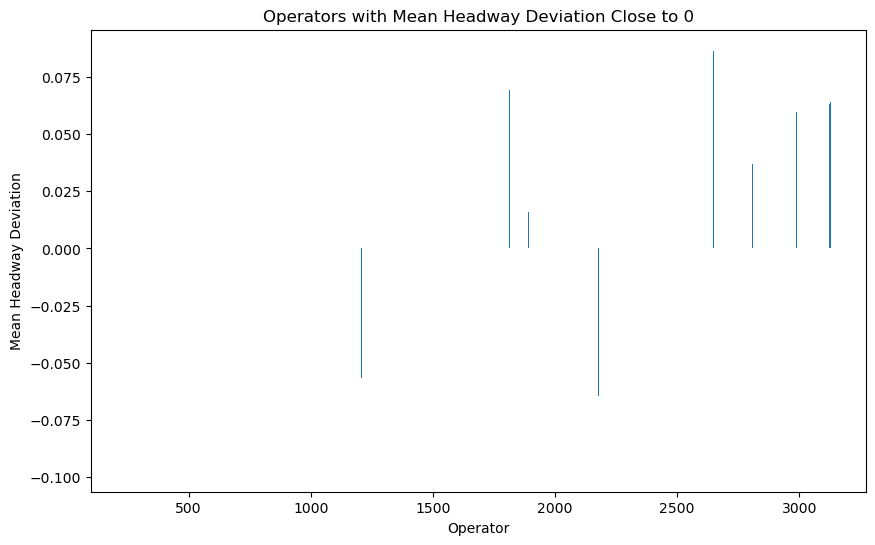

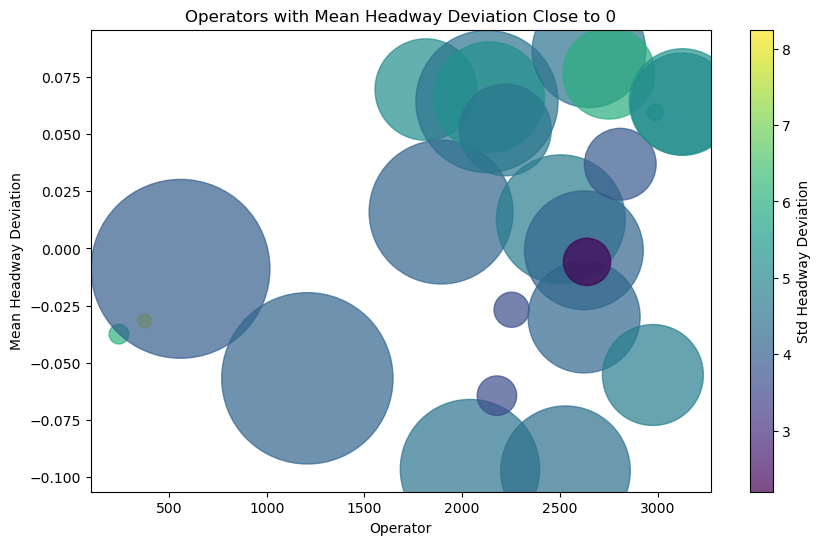

In [11]:
# Set the threshold for "close to 0"
threshold = 0.1

# Filter the DataFrame to find operators with mean headway deviation close to 0
close_to_0_operators = operator_stats[
    (operator_stats['mean_HDWY_DEV'] >= -threshold) & (operator_stats['mean_HDWY_DEV'] <= threshold)
]

# Create a bar plot to visualize mean headway deviations for close-to-0 operators
plt.figure(figsize=(10, 6))
plt.bar(close_to_0_operators['OPERATOR'], close_to_0_operators['mean_HDWY_DEV'])
plt.xlabel('Operator')
plt.ylabel('Mean Headway Deviation')
plt.title('Operators with Mean Headway Deviation Close to 0')
plt.show()

# Alternatively, you can create a scatter plot to visualize additional information
plt.figure(figsize=(10, 6))
plt.scatter(
    close_to_0_operators['OPERATOR'],
    close_to_0_operators['mean_HDWY_DEV'],
    s=close_to_0_operators['count_HDWY_DEV'] * 10,  # Scale the marker size based on count
    c=close_to_0_operators['std_HDWY_DEV'],  # Color based on std_HDWY_DEV
    cmap='viridis',  # Colormap for color mapping
    alpha=0.7  # Transparency
)
plt.xlabel('Operator')
plt.ylabel('Mean Headway Deviation')
plt.title('Operators with Mean Headway Deviation Close to 0')
plt.colorbar(label='Std Headway Deviation')
plt.show()

# plt.savefig('C:/Users/MJ/Data Science Bootcamp/Projects/temp/images/operators_w_mean_hdwydev_close_to_zero.png');

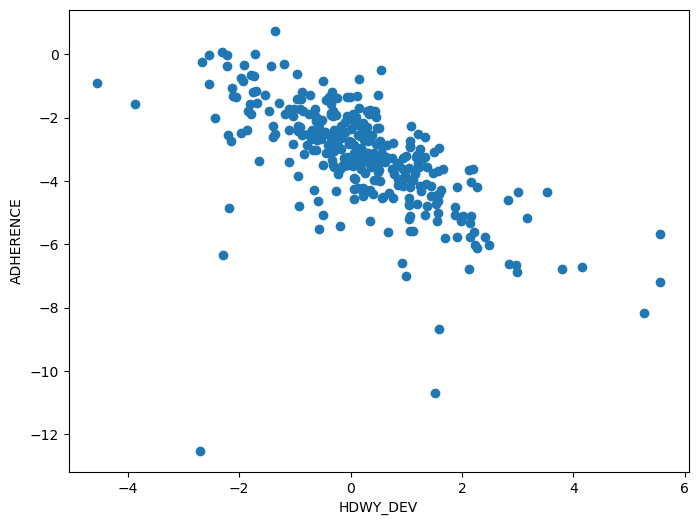

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(operator_stats['mean_HDWY_DEV'], operator_stats['mean_ADHERENCE'])
plt.xlabel("HDWY_DEV")
plt.ylabel("ADHERENCE")
plt.show()

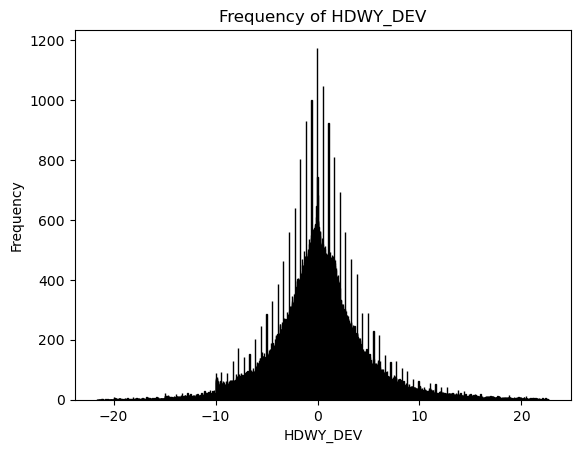

In [13]:
plt.hist(processed_data['HDWY_DEV'], bins=len(processed_data['HDWY_DEV'].unique()), edgecolor='k')
plt.xlabel('HDWY_DEV')
plt.ylabel('Frequency')
plt.title('Frequency of HDWY_DEV')
plt.show()


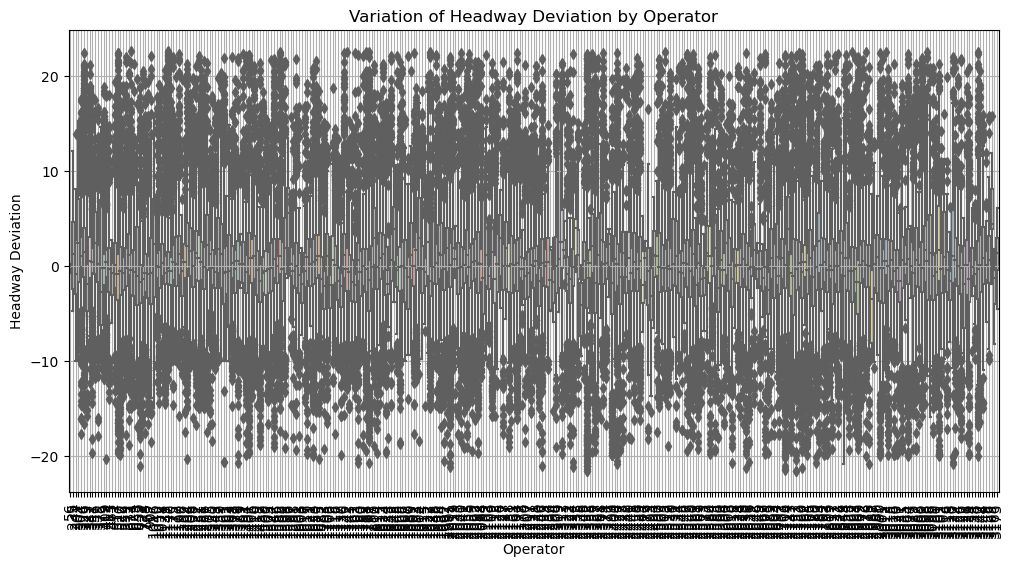

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=processed_data, x='OPERATOR', y='HDWY_DEV', palette='Set3')
plt.xlabel('Operator')
plt.ylabel('Headway Deviation')
plt.title('Variation of Headway Deviation by Operator')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

**Question:** Does the operator have any impact on the NEXT_ADHERENCE based on its PREVIOUS_ADHERENCE? 

In [15]:
lm = smf.ols('NEXT_ADHERENCE ~ OPERATOR + PREVIOUS_ADHERENCE', data = processed_data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         NEXT_ADHERENCE   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                 6.299e+04
Date:                Thu, 09 Nov 2023   Prob (F-statistic):               0.00
Time:                        11:44:26   Log-Likelihood:            -3.1762e+05
No. Observations:              130280   AIC:                         6.352e+05
Df Residuals:                  130277   BIC:                         6.353e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.7095      0.022    -32.884      0.000      -0.752      -0.667
OPERATOR              -0.0001   9.95e-06    -14.590      0.000      -0.000      -0.000
PREVIOUS_ADHERENCE     0.7451      0.002    353.454      0.000       0.741       0.749
==============================================================================
Omnibus:                    34749.018   Durbin-Watson:                   1.498
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           259318.932
Skew:                          -1.084   Prob(JB):                         0.00
Kurtosis:                       9.563   Cond. No.                     5.89e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Results:**
- R-squared of 0.492: this model explains about 49.2% of the variance in NEXT_ADHERENCE. 
- With a large F-statistic and a very low F-statistic p-value, this means this model is statistically significant. 
- The p-values associated with the t-statistics are very low (close to 0), which means that they're statistically significant. 

mean(NEXT_ADHERENCE) = -0.7095(NEXT_ADHERENCE) - .0001(OPERATOR) + .7451(PREVIOUS_ADHERENCE)
- For every unit change in PREVIOUS_ADHERENCE, NEXT_ADHERENCE is supposed to increase by .7451 units. With the OPERATOR being so close to zero, this means that it has no impact on NEXT_ADHERENCE. 

In [16]:
lm = smf.ols('NEXT_HDWY_DEV ~ OPERATOR + PREVIOUS_HDWY_DEV', data = processed_data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          NEXT_HDWY_DEV   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                 2.758e+04
Date:                Thu, 09 Nov 2023   Prob (F-statistic):               0.00
Time:                        11:44:26   Log-Likelihood:            -3.6982e+05
No. Observations:              130280   AIC:                         7.396e+05
Df Residuals:                  130277   BIC:                         7.397e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1509      0.031      4.854      0.000       0.090       0.212
OPERATOR          -5.109e-05   1.48e-05     -3.444      0.001   -8.02e-05    -2.2e-05
PREVIOUS_HDWY_DEV     0.5616      0.002    234.853      0.000       0.557       0.566
==============================================================================
Omnibus:                    18967.027   Durbin-Watson:                   1.531
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           224675.409
Skew:                           0.300   Prob(JB):                         0.00
Kurtosis:                       9.405   Cond. No.                     5.68e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
# Group the data by 'OPERATOR' and 'UNIQUE_TRIP_ID'
grouped_data = processed_data.groupby(['OPERATOR', 'UNIQUE_TRIP_ID'])

# Create a list to store DataFrames of results
results_dfs = []

# Iterate through the grouped data
for (operator, trip_id), group in grouped_data:
    mean_prev_hdwy_dev = group['PREVIOUS_HDWY_DEV'].mean()
    mean_next_hdwy_dev = group['NEXT_HDWY_DEV'].mean()
    
    # Create a DataFrame for the current group
    group_results = pd.DataFrame({'OPERATOR': [operator],
                                  'UNIQUE_TRIP_ID': [trip_id],
                                  'MEAN_PREVIOUS_HDWY_DEV': [mean_prev_hdwy_dev],
                                  'MEAN_NEXT_HDWY_DEV': [mean_next_hdwy_dev]})
    
    # Append the group's DataFrame to the list
    results_dfs.append(group_results)

# Concatenate all the DataFrames in the list to create 'results_df'
results_df = pd.concat(results_dfs, ignore_index=True)

# You now have a DataFrame 'results_df' that contains the mean previous adherence
# and mean next adherence for each trip, grouped by operator.
results_df.head()

,OPERATOR,UNIQUE_TRIP_ID,MEAN_PREVIOUS_HDWY_DEV,MEAN_NEXT_HDWY_DEV
0,56,120230818_353106,0.266666,-0.441667
1,235,120230830_350491,5.770833,4.200000
2,235,120230830_350492,-3.516667,-0.591667
3,235,120230830_350493,NaN,4.816666
4,244,120230918_352640,0.170833,-0.475000


**Question:** How does days of the week affect headway deviation or adherence? 

In [18]:
# Convert the DATE column to a datetime data type 
processed_data['DATE'] = pd.to_datetime(processed_data['DATE'])

# Create a new column to store the day of the week 
processed_data['Day_of_Week'] = processed_data['DATE'].dt.dayofweek + 1 
processed_data['Day_Type'] = processed_data['Day_of_Week'].apply(lambda x: 'Weekday' if 1 <= x <= 5 else 'Weekend')

processed_data.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,HDWY_DEV_PERC,Z_HDWY_DEV,Z_ADHERENCE,UNIQUE_TRIP_ID,PREVIOUS_ADHERENCE,NEXT_ADHERENCE,PREVIOUS_HDWY_DEV,NEXT_HDWY_DEV,Day_of_Week,Day_Type
0,120230801,1,99457899,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,-0.032222,-0.139835,0.510757,120230801_345106,NaN,-1.916666,NaN,1.966666,2,Weekday
1,120230801,1,99457898,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,0.056190,0.202259,0.244098,120230801_345106,-0.183333,-1.716666,-0.483334,2.666666,2,Weekday
2,120230801,1,99457897,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,0.076190,0.300000,0.274867,120230801_345106,-1.916666,NaN,1.966666,NaN,2,Weekday
3,120230801,1,99457901,2023-08-01,22,2200,1040,345107,0,FROM DOWNTOWN,...,-0.144444,-0.374878,0.336403,120230801_345107,NaN,1.500000,NaN,-3.883334,2,Weekday
4,120230801,1,99457902,2023-08-01,22,2200,1040,345107,0,FROM DOWNTOWN,...,-0.258889,-0.614577,0.769723,120230801_345107,-1.316666,NaN,-2.166667,NaN,2,Weekday


In [19]:
processed_data.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'BLOCK_STOP_ORDER',
       'DWELL_IN_MINS', 'HDWY_DEV_PERC', 'Z_HDWY_DEV', 'Z_ADHERENCE',
       'UNIQUE_TRIP_ID', 'PREVIOUS_ADHERENCE', 'NEXT_ADHERENCE',
       'PREVIOUS_HDWY_DEV', 'NEXT_HDWY_DEV', 'Day_of_Week', 'Day_Type'],
      dtype='object')

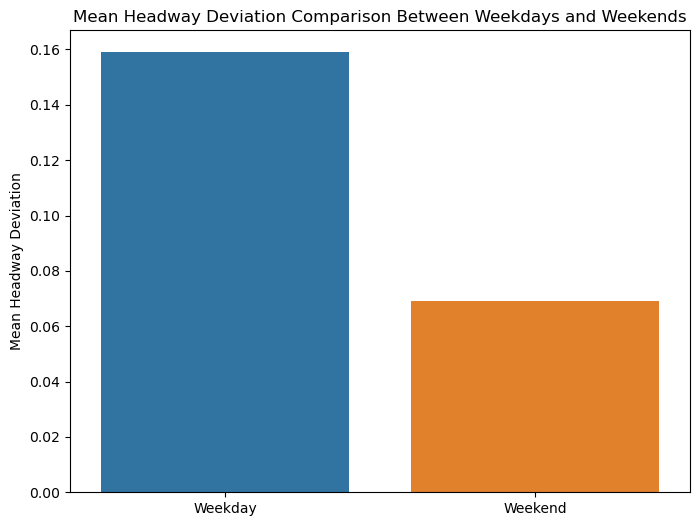

In [20]:
# Filter data for weekdays and weekends
weekday_data = processed_data[processed_data['Day_Type'] == 'Weekday']
weekend_data = processed_data[processed_data['Day_Type'] == 'Weekend']

# Set up the data for plotting
data_to_plot = [weekday_data['HDWY_DEV'], weekend_data['HDWY_DEV']]

# Create a bar plot with error bars
plt.figure(figsize=(8, 6))
sns.barplot(x=['Weekday', 'Weekend'], y=[data.mean() for data in data_to_plot], errcolor='gray', capsize=0.2)
plt.ylabel('Mean Headway Deviation')
plt.title('Mean Headway Deviation Comparison Between Weekdays and Weekends')

# plt.savefig('C:/Users/MJ/Data Science Bootcamp/Projects/temp/wego_project/images/mean_hdwy_dev_comparison_types_of_day.png');
plt.show()

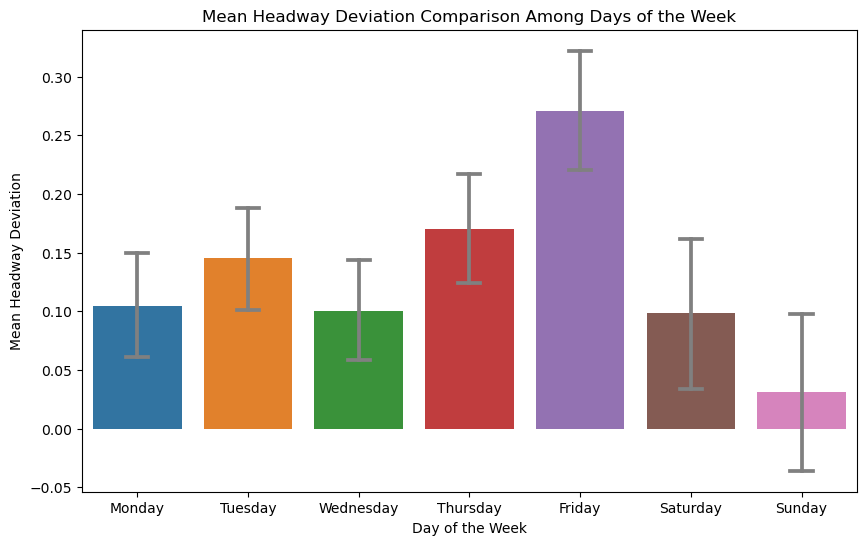

In [21]:
# Create a bar plot with error bars
plt.figure(figsize=(10, 6))
sns.barplot(x='Day_of_Week', y='HDWY_DEV', data=processed_data, errcolor='gray', capsize=0.2)
plt.ylabel('Mean Headway Deviation')
plt.xlabel('Day of the Week')
plt.title('Mean Headway Deviation Comparison Among Days of the Week')
# plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Dictionary for custom x tick labels 
day_order = {
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday',
    7: 'Sunday'
}

# Set custom x-axis labels
custom_labels = [day_order[i] for i in range(1, 8)]
plt.xticks(range(7), custom_labels)

# plt.savefig('C:/Users/MJ/Data Science Bootcamp/Projects/temp/images/mean_hdwy_dev_comparison.png');
plt.show();

**Question:** Are there specific days that have a wide range of deviation from headway? 

In [22]:
# Encode 'Day_Type' as a categorical variable
processed_data['Day_Type'] = processed_data['Day_Type'].astype('category')

# Create dummy variables for 'Day_Type' (one-hot encoding)
day_type_dummies = pd.get_dummies(processed_data['Day_Type'], prefix='Day_Type')

# Add the dummy variables to the DataFrame
processed_data = pd.concat([processed_data, day_type_dummies], axis=1)

In [23]:
lm = smf.ols('HDWY_DEV ~ Day_Type_Weekday + Day_Type_Weekend', data = processed_data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               HDWY_DEV   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     13.70
Date:                Thu, 09 Nov 2023   Prob (F-statistic):           0.000214
Time:                        11:45:17   Log-Likelihood:            -7.5907e+05
No. Observations:              254299   AIC:                         1.518e+06
Df Residuals:                  254297   BIC:                         1.518e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0760      0.008      9.373      0.000       0.060       0.092
Day_Type_Weekday     0.0830      0.010      8.191      0.000       0.063       0.103
Day_Type_Weekend    -0.0070      0.015     -0.467      0.640      -0.036       0.022
==============================================================================
Omnibus:                    19977.617   Durbin-Watson:                   0.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            70186.392
Skew:                           0.362   Prob(JB):                         0.00
Kurtosis:                       5.470   Cond. No.                     5.05e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.73e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**Interpretation:**

- The model does not explain much of the variance in 'HDWY_DEV' as indicated by the low R-squared value.
- The **'Day_Type_Weekday' coefficient is statistically significant (p-value is 0.000),** suggesting that 'Day_Type' has an influence on 'HDWY_DEV' on weekdays.
- The 'Day_Type_Weekend' coefficient is not statistically significant (p-value is 0.640), suggesting that 'Day_Type' does not have a statistically significant influence on 'HDWY_DEV' on weekends.
- The presence of significant multicollinearity issues is indicated by the small eigenvalue.

In [24]:
lm = smf.ols('HDWY_DEV ~ Day_of_Week', data = processed_data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               HDWY_DEV   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1545
Date:                Thu, 09 Nov 2023   Prob (F-statistic):              0.694
Time:                        11:45:17   Log-Likelihood:            -7.5907e+05
No. Observations:              254299   AIC:                         1.518e+06
Df Residuals:                  254297   BIC:                         1.518e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1346      0.021      6.329      0.000       0.093       0.176
Day_of_Week     0.0020      0.005      0.393      0.694      -0.008       0.012
==============================================================================
Omnibus:                    19983.271   Durbin-Watson:                   0.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            70349.799
Skew:                           0.362   Prob(JB):                         0.00
Kurtosis:                       5.473   Cond. No.                         9.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Interpretation:** 

The results suggest that the "Day_of_Week" variable does not have a significant impact on explaining the variation in "HDWY_DEV." The model is not a good fit for the data, and there is no evidence to support a strong relationship between the day of the week and headway deviation based on this analysis.

In [25]:
bna_weather = pd.read_csv("../data/bna_weather.csv")
bna_weather.head(4)

,STATION,NAME,DATE,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT08
0,USW00013897,"NASHVILLE INTERNATIONAL AIRPORT, TN US",2023-08-01,6.49,NaN,0.00,0.0,0.0,80,89,70,50,10,13.0,21.0,NaN,NaN,NaN,NaN
1,USW00013897,"NASHVILLE INTERNATIONAL AIRPORT, TN US",2023-08-02,2.91,NaN,0.00,0.0,0.0,77,86,65,150,180,8.1,12.1,NaN,NaN,NaN,NaN
2,USW00013897,"NASHVILLE INTERNATIONAL AIRPORT, TN US",2023-08-03,4.92,NaN,1.19,0.0,0.0,77,81,72,230,300,12.1,29.1,1.0,NaN,1.0,NaN
3,USW00013897,"NASHVILLE INTERNATIONAL AIRPORT, TN US",2023-08-04,2.24,NaN,0.12,0.0,0.0,78,84,73,270,40,8.9,14.1,1.0,NaN,NaN,NaN


In [26]:
Transit_Bus_Stops = pd.read_csv("../data/WeGo_Transit_Bus_Stops_20231025.csv")
Transit_Bus_Stops.head(4)

,Stop ID,Stop Abbreviation,Stop Name,Shelter?,Bench?,Route Numbers,Route Name,Mapped Location
0,5120,7AVUNINN,7TH AVE & UNION ST NB,False,False,NaN,AIRPORT - DOWNTOWN HOTELS,NaN
1,5455,CM5_4,Temporary Bay 4,False,False,NaN,HERMAN,NaN
2,2762,23ACLASF,23RD AVE N & CLARKSVILLE PIKE SB,False,False,22,BORDEAUX,NaN
3,4079,21ACHUSN,21ST AVE N & CHURCH ST SB,False,True,25,MIDTOWN,NaN


**Question:** How does times of day and day impact headway deviation? 